<a href="https://colab.research.google.com/github/anshika3011/Dissertation/blob/main/Analysis_on_StackOverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading the dataset
import pandas as pd
def load_dataset(file_path):
    data = pd.read_csv(file_path, sep=',', on_bad_lines='skip')
    return data


In [ ]:
data_stackoverflow = load_dataset('train-sample.csv')

In [ ]:
data_stackoverflow.shape

(140272, 15)

In [ ]:
data_stackoverflow.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open


In [ ]:
data_stackoverflow = data_stackoverflow[['Title', 'BodyMarkdown', 'OpenStatus']]
data_stackoverflow.head()

,Title,BodyMarkdown,OpenStatus
0,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,open
1,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,open
2,Too many lookup tables,What are the adverse effects of having too man...,open
3,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,too localized
4,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",open


In [ ]:
data_stackoverflow['Text'] = data_stackoverflow['Title'] + ' ' + data_stackoverflow['BodyMarkdown']
data_stackoverflow = data_stackoverflow.drop(columns = ['Title', 'BodyMarkdown'])
data_stackoverflow.head(5)

,OpenStatus,Text
0,open,For Mongodb is it better to reference an objec...
1,open,How to insert schemalocation in a xml document...
2,open,Too many lookup tables What are the adverse e...
3,too localized,What is this PHP code in VB.net I am looking f...
4,open,Spring-Data mongodb querying multiple classes ...


Exploratory Data analysis

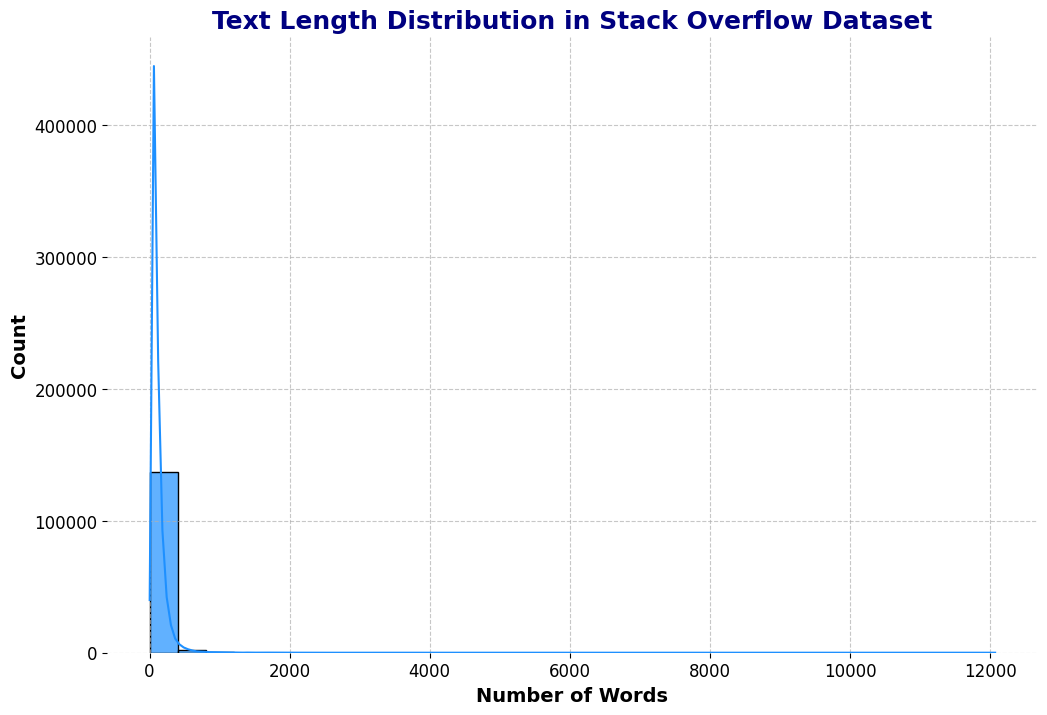

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating the length of the combined text (Title+BodyMarkdown)
data_stackoverflow['TextLength'] = data_stackoverflow['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 8))
sns.histplot(data_stackoverflow['TextLength'], kde=True, color='dodgerblue', bins=30, alpha=0.7)
plt.title('Text Length Distribution in Stack Overflow Dataset', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Number of Words', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)
plt.show()


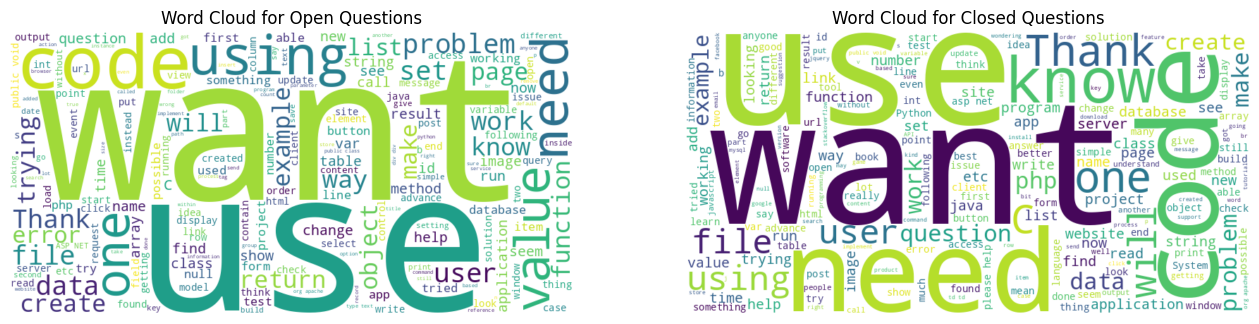

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generating word cloud for open questions
open_text = ' '.join(data_stackoverflow[data_stackoverflow['OpenStatus'] == 'open']['Text'])
wordcloud_open = WordCloud(width=800, height=400, background_color='white').generate(open_text)

# Generating word cloud for closed questions
closed_text = ' '.join(data_stackoverflow[data_stackoverflow['OpenStatus'] != 'open']['Text'])
wordcloud_closed = WordCloud(width=800, height=400, background_color='white').generate(closed_text)

# Plot the word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_open, interpolation='bilinear')
plt.title('Word Cloud for Open Questions')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_closed, interpolation='bilinear')
plt.title('Word Cloud for Closed Questions')
plt.axis('off')
plt.show()


APPLYING TRADITIONAL MACHINE LEARNING MODELS

Applying Logistic Regression With Polynomial feature

In [ ]:
#Preprocessing function to clean the text
import re
import string
import pandas as pd
import numpy as np



def clean_text(text):
    #convert to lowercase
    text = text.lower()
    # Removing punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    #Removing digits
    text = re.sub(r'\d+', '', text)
    #Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
#Calling data cleaning function
data_stackoverflow['Text'] = data_stackoverflow['Text'].apply(clean_text)

#Calculating text length and number of special characters
data_stackoverflow['text_length'] = data_stackoverflow['Text'].apply(len)
data_stackoverflow['num_special_chars'] = data_stackoverflow['Text'].apply(lambda x: sum(1 for char in x if not char.isalnum()))

#Encoding target labels for binary classification
data_stackoverflow['OpenStatus'] = data_stackoverflow['OpenStatus'].map({
    'open': 0,
    'not a real question': 1,
    'off topic': 1,
    'not constructive': 1,
    'too localized': 1
})

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import itertools

#Splitingt data into training and testing sets
X = data_stackoverflow['Text']
y = data_stackoverflow['OpenStatus']
X_features = data_stackoverflow[['text_length', 'num_special_chars']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xtrain_features, xtest_features = train_test_split(X_features, test_size=0.2, random_state=42)


In [ ]:
#Converting words to numbers using TF-IDF
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))
xtrain_tfidf = vectorizer.fit_transform(X_train)
xtest_tfidf = vectorizer.transform(X_test)

In [ ]:
#Adding polynomial features to the additional features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
xtrain_poly_features = poly.fit_transform(xtrain_features)
xtest_poly_features = poly.transform(xtest_features)

#Combining TF-IDF and polynomial features
xtrain_combined = hstack([xtrain_tfidf, xtrain_poly_features])
xtest_combined = hstack([xtest_tfidf, xtest_poly_features])

In [ ]:
#Logistic Regression classifier with hyperparameter tuning using GridSearch
param_grid = {'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
logit = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(logit, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xtrain_combined, y_train)

best_logit = grid_search.best_estimator_

predicted_logit = best_logit.predict(xtest_combined)


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:44: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Accuracy Score 
 0.7529495633576903
Confusion Matrix 
 [[10634  3627]
 [ 3304 10490]]
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.75      0.75     14261
           1       0.74      0.76      0.75     13794

    accuracy                           0.75     28055
   macro avg       0.75      0.75      0.75     28055
weighted avg       0.75      0.75      0.75     28055



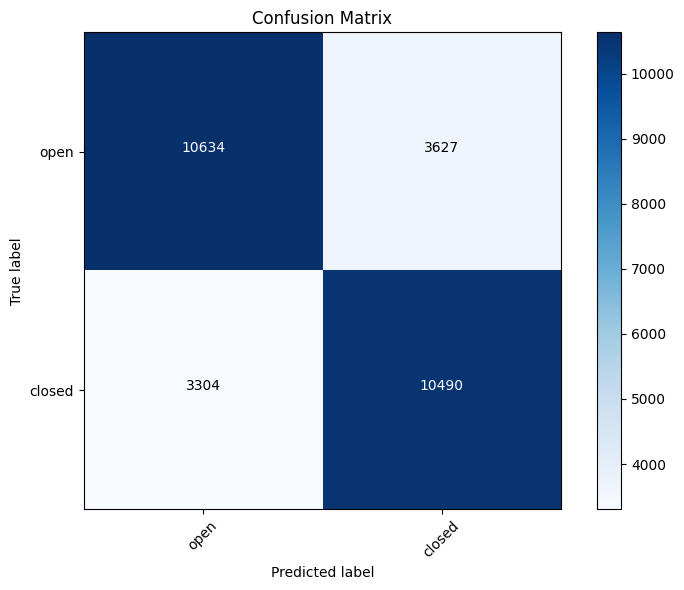

In [ ]:
#Evaluating the model
accuracy = accuracy_score(predicted_logit, y_test)
conf_matrix = confusion_matrix(predicted_logit, y_test)
class_report = classification_report(predicted_logit, y_test)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

#Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['open', 'closed'], rotation=45)
plt.yticks(tick_marks, ['open', 'closed'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


Using the stacking classifier

In [ ]:
#Loading the dataset
data_stackoverflow = load_dataset('train-sample.csv')
#Applying data cleaning
data_stackoverflow['Text'] = data_stackoverflow['Title'] + ' ' + data_stackoverflow['BodyMarkdown']
data_stackoverflow['Text'] = data_stackoverflow['Text'].apply(clean_text)

#Calculating text length and number of special characters
data_stackoverflow['text_length'] = data_stackoverflow['Text'].apply(len)
data_stackoverflow['num_special_chars'] = data_stackoverflow['Text'].apply(lambda x: sum(1 for char in x if not char.isalnum()))

#Encoding target labels for binary classification
data_stackoverflow['OpenStatus'] = data_stackoverflow['OpenStatus'].map({
    'open': 0,
    'not a real question': 1,
    'off topic': 1,
    'not constructive': 1,
    'too localized': 1
})

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import itertools

#Splitting data into training and testing sets
X = data_stackoverflow['Text']
y = data_stackoverflow['OpenStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Converting words to numbers using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
xtrain_tfidf = vectorizer.fit_transform(X_train)
xtest_tfidf = vectorizer.transform(X_test)

In [ ]:
#Combining TF-IDF and additional features
xtrain_features = data_stackoverflow[['text_length', 'num_special_chars']].iloc[X_train.index]
xtest_features = data_stackoverflow[['text_length', 'num_special_chars']].iloc[X_test.index]
xtrain_combined = hstack([xtrain_tfidf, xtrain_features])
xtest_combined = hstack([xtest_tfidf, xtest_features])

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
#Defining base models
base_models = [
    ('lr', LogisticRegression(max_iter=500, random_state=42)),
    ('nb', MultinomialNB()),
    ('dt', DecisionTreeClassifier(random_state=42))
]

#Defining Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=3,
    n_jobs=-1
)

#Train the Stacking Classifier
stacking_clf.fit(xtrain_combined, y_train)

#Predict with Stacking Classifier
predicted_stack = stacking_clf.predict(xtest_combined)

Accuracy Score 
 0.7175904473355909
Confusion Matrix 
 [[10068  4053]
 [ 3870 10064]]
Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.71      0.72     14121
           1       0.71      0.72      0.72     13934

    accuracy                           0.72     28055
   macro avg       0.72      0.72      0.72     28055
weighted avg       0.72      0.72      0.72     28055



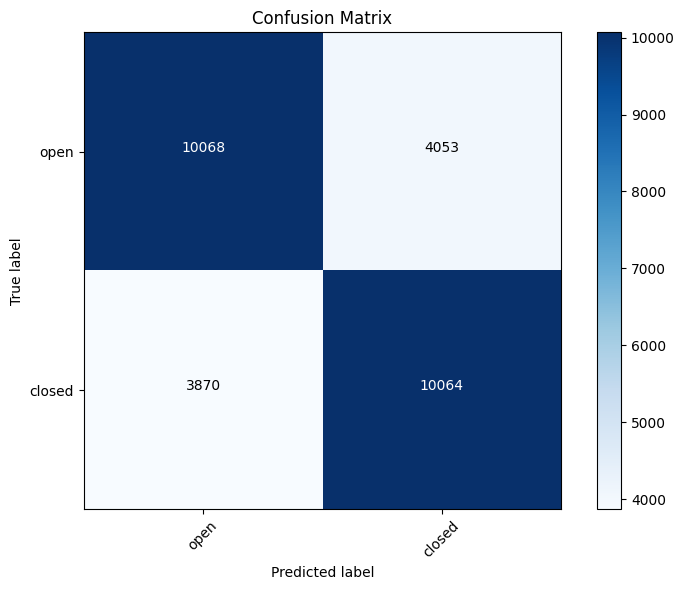

In [ ]:
# Evaluate the Stacking Classifier
accuracy = accuracy_score(predicted_stack, y_test)
conf_matrix = confusion_matrix(predicted_stack, y_test)
class_report = classification_report(predicted_stack, y_test)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['open', 'closed'], rotation=45)
plt.yticks(tick_marks, ['open', 'closed'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

APPLYING DECODER BASED MODEL

Applying BERT

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification

#checking GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#Loading the dataset
data_stackoverflow = load_dataset('train-sample.csv')
# Apply data cleaning
data_stackoverflow['Text'] = data_stackoverflow['Title'] + ' ' + data_stackoverflow['BodyMarkdown']
data_stackoverflow['Text'] = data_stackoverflow['Text'].apply(clean_text)

# Encode target labels for binary classification
label_id = {'open': 0, 'not a real question': 1, 'off topic': 1, 'not constructive': 1, 'too localized': 1}
data_stackoverflow['OpenStatus'] = data_stackoverflow['OpenStatus'].map(label_id)

Num GPUs Available:  1


In [ ]:
# Split data into training and test sets
X = data_stackoverflow['Text']
y = data_stackoverflow['OpenStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Loading the pre-trained BERT model tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )


In [ ]:
#Caling the encode_texts function
x_train_encoded = encode_texts(X_train, tokenizer)
x_test_encoded = encode_texts(X_test, tokenizer)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#Adding Dropout and L2 Regularization to the model
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Prepare datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_encoded), y_train)).shuffle(10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test_encoded), y_test)).batch(batch_size)

#Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-7
)

#Train the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
3507/3507 [==============================] - 1065s 291ms/step - loss: 0.4913 - accuracy: 0.7662 - val_loss: 0.4907 - val_accuracy: 0.7724 - lr: 2.0000e-05
Epoch 2/5
3507/3507 [==============================] - 1018s 290ms/step - loss: 0.4183 - accuracy: 0.8120 - val_loss: 0.4892 - val_accuracy: 0.7728 - lr: 2.0000e-05
Epoch 3/5
3507/3507 [==============================] - 1019s 291ms/step - loss: 0.3259 - accuracy: 0.8625 - val_loss: 0.5555 - val_accuracy: 0.7721 - lr: 2.0000e-05
Epoch 4/5
3507/3507 [==============================] - 1017s 290ms/step - loss: 0.1766 - accuracy: 0.9346 - val_loss: 0.7545 - val_accuracy: 0.7587 - lr: 4.0000e-06


877/877 [==============================] - 79s 91ms/step - loss: 0.4892 - accuracy: 0.7728
Validation Loss: 0.48923733830451965, Validation Accuracy: 0.7727677822113037
877/877 [==============================] - 81s 88ms/step
Accuracy Score 
 0.772767777579754
Confusion Matrix 
 [[ 9855  4173]
 [ 2202 11825]]
Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.70      0.76     14028
           1       0.74      0.84      0.79     14027

    accuracy                           0.77     28055
   macro avg       0.78      0.77      0.77     28055
weighted avg       0.78      0.77      0.77     28055



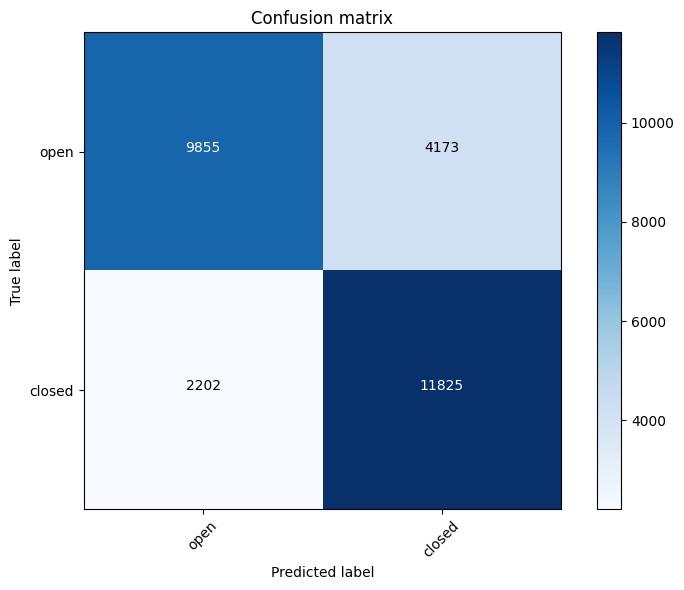

In [ ]:
# Evaluate the BERT model
val_loss, val_accuracy = model.evaluate(test_dataset)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Predict on validation dataset
val_predictions = model.predict(test_dataset)
val_predictions = np.argmax(val_predictions.logits, axis=1)

# Model Evaluation
accuracy = accuracy_score(y_test, val_predictions)
conf_matrix = confusion_matrix(y_test, val_predictions)
class_report = classification_report(y_test, val_predictions)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['open', 'closed'], rotation=45)
plt.yticks(tick_marks, ['open', 'closed'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Applying XML-R

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification

#checking GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#Loading the dataset
data_stackoverflow = load_dataset('train-sample.csv')
# Apply data cleaning
data_stackoverflow['Text'] = data_stackoverflow['Title'] + ' ' + data_stackoverflow['BodyMarkdown']
data_stackoverflow['Text'] = data_stackoverflow['Text'].apply(clean_text)

# Encode target labels for binary classification
label_id = {'open': 0, 'not a real question': 1, 'off topic': 1, 'not constructive': 1, 'too localized': 1}
data_stackoverflow['OpenStatus'] = data_stackoverflow['OpenStatus'].map(label_id)

Num GPUs Available:  1


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
#Splitting data into training and test sets
X = data_stackoverflow['Text']
y = data_stackoverflow['OpenStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Load the pre-trained XLM-R tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Encode texts
x_train_encoded = encode_texts(X_train, tokenizer)
x_test_encoded = encode_texts(X_test, tokenizer)

In [ ]:
from transformers import AutoTokenizer, TFXLMRobertaForSequenceClassification
model = TFXLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_encoded), y_train)).shuffle(10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test_encoded), y_test)).batch(batch_size)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-7
)
# Train the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
3507/3507 [==============================] - 438s 113ms/step - loss: 0.5089 - accuracy: 0.7549 - val_loss: 0.4833 - val_accuracy: 0.7696 - lr: 2.0000e-05
Epoch 2/5
3507/3507 [==============================] - 382s 109ms/step - loss: 0.4609 - accuracy: 0.7874 - val_loss: 0.4684 - val_accuracy: 0.7817 - lr: 2.0000e-05
Epoch 3/5
3507/3507 [==============================] - 380s 108ms/step - loss: 0.4292 - accuracy: 0.8052 - val_loss: 0.4807 - val_accuracy: 0.7839 - lr: 2.0000e-05
Epoch 4/5
3507/3507 [==============================] - 381s 109ms/step - loss: 0.3579 - accuracy: 0.8470 - val_loss: 0.5209 - val_accuracy: 0.7809 - lr: 4.0000e-06


In [ ]:
#Predict on validation dataset
val_predictions_proba = model.predict(test_dataset)
val_predictions_proba = tf.nn.softmax(val_predictions_proba.logits, axis=-1)[:, 1].numpy()
#Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, val_predictions_proba)
roc_auc = auc(fpr, tpr)

#Determining the predictions based on a threshold  of 0.5
val_predictions = (val_predictions_proba > 0.5).astype(int)

#Model Evaluation using Accuracy, Confusion Matrix, and Classification Report
accuracy = accuracy_score(y_test, val_predictions)
conf_matrix = confusion_matrix(y_test, val_predictions)
class_report = classification_report(y_test, val_predictions)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

877/877 [==============================] - 34s 39ms/step
Accuracy Score 
 0.781678845125646
Confusion Matrix 
 [[10227  3801]
 [ 2324 11703]]
Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.73      0.77     14028
           1       0.75      0.83      0.79     14027

    accuracy                           0.78     28055
   macro avg       0.78      0.78      0.78     28055
weighted avg       0.78      0.78      0.78     28055



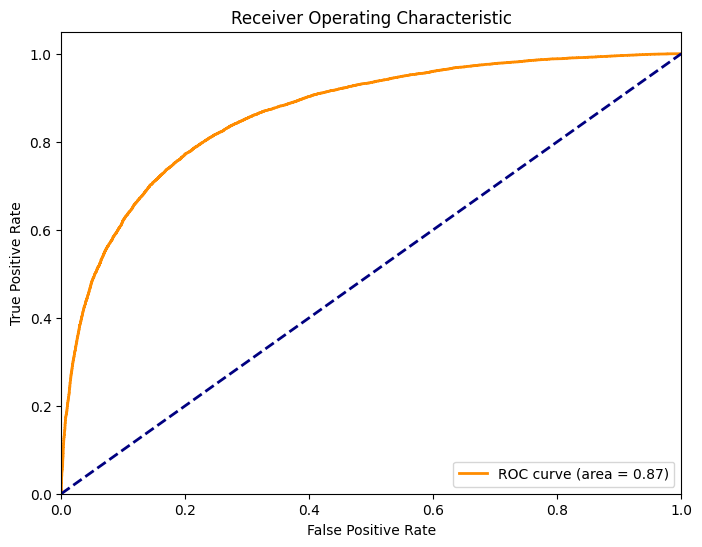

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

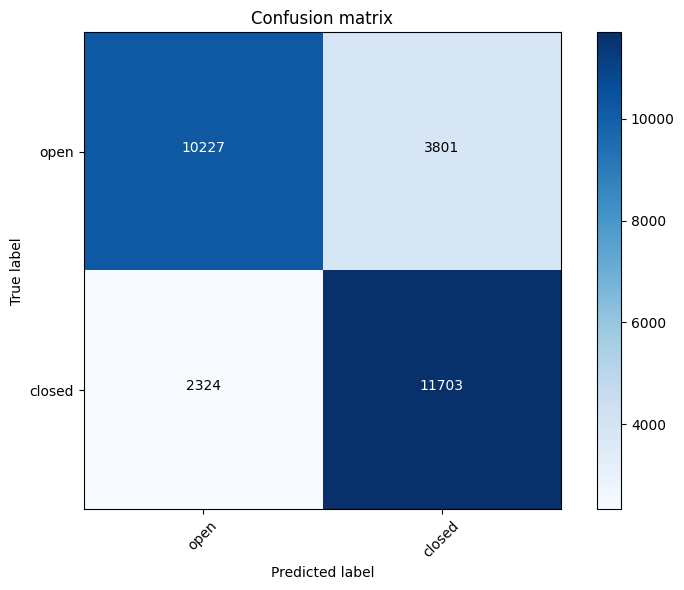

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['open', 'closed'], rotation=45)
plt.yticks(tick_marks, ['open', 'closed'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()